<a href="https://colab.research.google.com/github/Aadil404/Music-Emotion-Recognition/blob/main/notebooks/00_Data_Consolidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Navigate to your project directory (adjust the path if needed)
%cd /content/drive/MyDrive/MER(final-year-project)/

# 3. Install necessary libraries
!pip install librosa tensorflow pandas scikit-learn matplotlib seaborn

Mounted at /content/drive
/content/drive/MyDrive/MER(final-year-project)


In [ ]:
import pandas as pd
import os


file_name = 'data/emotify_dataset/metadata.csv'
if not os.path.exists(file_name):
    print(f"Error: '{file_name}' not found. Please upload the file and run this cell again.")
else:
    print(f"'{file_name}' found! Processing...")
    df = pd.read_csv(file_name)

    # 1. Create the song path column
    def get_song_path(row):
        genre = row[' genre'].strip()
        track_id = row['track id']
        if track_id >= 1 and track_id <= 100:
            return f"{genre}/{track_id}.mp3"
        elif track_id >= 101 and track_id <= 200:
            return f"{genre}/{track_id - 100}.mp3"
        elif track_id >= 201 and track_id <= 300:
            return f"{genre}/{track_id - 200}.mp3"
        elif track_id >= 301 and track_id <= 400:
            return f"{genre}/{track_id - 300}.mp3"
        else:
            return None # Handle cases outside the expected range

    df['songs_path'] = df.apply(get_song_path, axis=1)

    # 2. Identify the emotion columns
    emotion_columns = df.columns[2:11]
    print(f"Using emotion columns: {list(emotion_columns)}")

    # 3. Consolidate labels: Convert to weighted probabilities
    # Calculate the number of listeners for each song
    listener_counts = df.groupby('songs_path').size().reset_index(name='listener_count')

    # Group by songs_path and sum the emotion votes
    emotion_votes = df.groupby('songs_path')[emotion_columns].sum().reset_index()

    # Merge listener counts with emotion votes
    df_aggregated = pd.merge(emotion_votes, listener_counts, on='songs_path')

    # Calculate weighted probabilities
    for col in emotion_columns:
        df_aggregated[col] = df_aggregated.apply(lambda row: row[col] / row['listener_count'], axis=1)

    # Drop the listener_count column as it's no longer needed
    df_consolidated = df_aggregated.drop(columns=['listener_count'])

    # Shuffle the consolidated DataFrame
    df_consolidated = df_consolidated.sample(frac=1).reset_index(drop=True)

    # 4. Save the new cleaned metadata
    output_path = 'data/emotify_dataset/cleaned_metadata_weighted_probabilities.csv'
    df_consolidated.to_csv(output_path, index=False)

    print(f"\n✅ Successfully created '{output_path}'.")
    print("\nPreview of the new metadata:")
    print(df_consolidated.head())

'data/emotify_dataset/metadata.csv' found! Processing...
Using emotion columns: [' amazement', ' solemnity', ' tenderness', ' nostalgia', ' calmness', ' power', ' joyful_activation', ' tension', ' sadness']

✅ Successfully created 'data/emotify_dataset/cleaned_metadata_weighted_probabilities.csv'.

Preview of the new metadata:
          songs_path   amazement   solemnity   tenderness   nostalgia  \
0         pop/64.mp3    0.083333    0.083333     0.250000    0.333333   
1  electronic/56.mp3    0.181818    0.000000     0.090909    0.000000   
2        rock/79.mp3    0.142857    0.142857     0.000000    0.214286   
3          pop/7.mp3    0.047619    0.190476     0.404762    0.523810   
4  electronic/75.mp3    0.181818    0.363636     0.000000    0.181818   

    calmness     power   joyful_activation   tension   sadness  
0   0.500000  0.000000            0.000000  0.250000  0.500000  
1   0.090909  0.454545            0.090909  0.727273  0.272727  
2   0.071429  0.000000            0.7

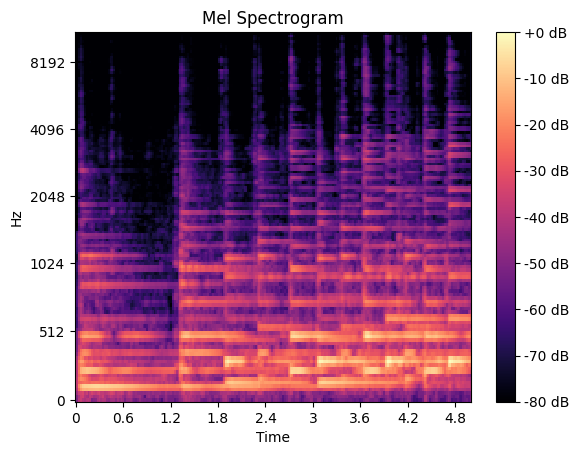

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
# Function to create a Mel Spectrogram
def create_mel_spectrogram(audio_path):
    y, sr = librosa.load(audio_path, duration=5)  # Load audio, use first 45s
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec

# Example: Create and display a spectrogram for the first song
first_song_path = 'data/emotify_dataset/' + df.iloc[365]['songs_path']
spectrogram = create_mel_spectrogram(first_song_path)

librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


In [ ]:
spectrogram.shape

(128, 216)